# Shapiro Diagram Simulation with Resistively Shunt Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
from scipy.io import savemat
from scipy.integrate import odeint
%matplotlib inline

In [3]:
%load_ext Cython

### Resistively Shunted Model:

$\frac{d\phi}{dt}=\frac{2eR_N}{\hbar}[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-I_C\sin\phi]$

Solving $\phi(t)$, then you can get the voltage difference between the superconducting leads:

$V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle$

After Normalizing:
$I_{DC}\leftrightarrow \tilde{I_{DC}}=I_{DC}/I_C$,

$I_{RF} \leftrightarrow \tilde{I_{RF}}=I_{RF}/I_C$,

$ V \leftrightarrow \tilde{V}=\frac{V}{I_CR_N}$,

$ R=\frac{dV}{dI} \leftrightarrow \tilde{R}=\frac{R}{R_N}$,


$\because f_0=2eI_CR_N/h$,

$f_{RF} \leftrightarrow \tilde{f_{RF}}=f_{RF}/f_0$,

$t \leftrightarrow \tilde{t}=f_0t$,

The Josephson voltage quantized at $\frac{V}{hf_{RF}f_0/2e}=n \leftrightarrow \frac{V}{f_{RF}f_0}=n$ 

Here, we can set $f_0=1$ or $\frac{I_CR_N}{hf_0/2e}=1$, without loss of generality

The RSJ model simply becomes (omitting $\tilde{}$):

$\frac{d\phi}{dt}=[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-\sin\phi]$

At equilibrium, $V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle \leftrightarrow \tilde{V}=\frac{1}{2\pi}\langle\frac{d\phi}{d\tilde{t}}\rangle$  would also quantized at integers in the Shapiro step regime.



### Cython codes here is to speed up the simulation because python is slower than C:

In [52]:
%%cython --pgo
#To use GNU compiler gcc-10 specified in .bash_profile


cimport numpy as np
from libc.math cimport sin,pi

### cdef is faster but can only be used for cython in this cell
#cpdef can be used for python outside this cell

cdef double CPR(double G):
    '''
        Current-phase relationship for the junction. Normally sinusoidal, can be other function for complex materials.
    '''
    return sin(G)
    
cpdef double dGdt(G,double t,double i_dc,double i_ac,double f_rf):
    '''
        RSJ model
    '''
    der = -CPR(G) + i_dc + i_ac * sin(2*pi*f_rf*t)
    return der 

In [53]:
f_rf=0.5 # you can adjust the driving frequency here.
IDC_array=np.linspace(-5,5,101)
IRF_array=np.linspace(0,10,101)
IDC_step=IDC_array[1]-IDC_array[0]
print("IDC step: ",round(IDC_step,2))

print("DC array size: "+str(len(IDC_array)))
print("RF array size: "+str(len(IRF_array)))

print("Driving RF frequency f_rf = "+str(f_rf))

IDC step:  0.1
DC array size: 101
RF array size: 101
Driving RF frequency f_rf = 0.5


### Test on one RF current

In [60]:
t=np.arange(0,300.01,0.01)
V=np.empty([len(IDC_array)])
for i in range(0,len(IDC_array)):
    G_array= odeint(dGdt,0,t,args=(IDC_array[i],8,f_rf))
    V[i]=np.mean(np.gradient(G_array[-10000:,0]))
V=V/0.01/(2*np.pi)
DVDI=2*np.pi*np.gradient(V,IDC_step) #differential resistance dV/dI


JV=f_rf#h*f_array[0]*f0/2/Qe

(0.0, 5.0)

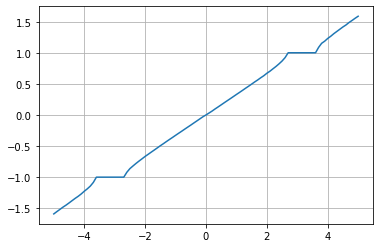

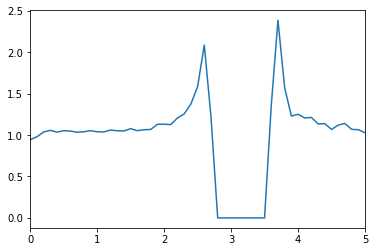

In [61]:
plt.figure()
plt.plot(IDC_array,V/JV)
plt.grid()
plt.figure()
plt.plot(IDC_array,DVDI)
plt.xlim([0,5])

In [49]:
T1=datetime.now()
print (T1)
V=np.empty([len(IRF_array),len(IDC_array)])
DVDI=np.empty([len(IRF_array),len(IDC_array)])

for i in range(0,len(IRF_array)):
    print("RF current now: "+str(IRF_array[i])+" ,"+str(datetime.now()),end='\r')
    for j in range(0,len(IDC_array)):
        t=np.arange(0,300.01,0.01) # 300 periods
        G_array= odeint(dGdt,0,t,args=(IDC_array[j],IRF_array[i],f_rf))
        V[i,j]=np.mean(np.gradient(G_array[:-1501,0]))/0.01/(2*np.pi)
    
DVDI=2*np.pi*np.gradient(V,IDC_step,axis=1) #differential resistance dV/dI

print ("\n It takes " + str(datetime.now()-T1))

2020-09-24 23:14:13.421224
RF current now: 10.0 ,2020-09-24 23:17:16.319319:17:09.24636655
 It takes 0:03:05.222995


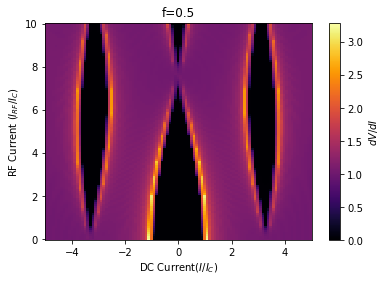

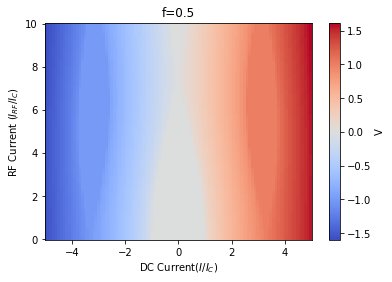

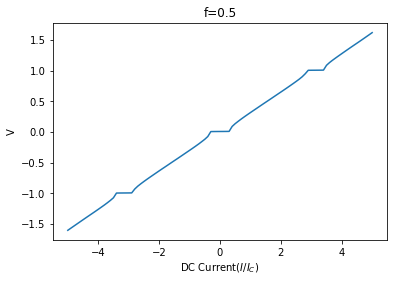

In [51]:
plt.figure()
plt.pcolormesh(IDC_array, IRF_array, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading='auto')
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_{RF}/I_C$)")
plt.colorbar(label = "$dV/dI$")
plt.title("f="+str(f_rf))

#plt.savefig("DVDI_"+str(f_rf)+".pdf")
plt.show()
                
plt.figure()
plt.pcolormesh(IDC_array, IRF_array, V/f_rf , cmap = 'coolwarm',linewidth=0,rasterized=True,shading='auto')
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_{RF}/I_C$)")
plt.colorbar(label = "V")
plt.title("f="+str(f_rf))
#plt.savefig("V_"+"w="+str(w_rf)+".pdf")
plt.show()

#savemat("data_f="+str(f_rf)+'.mat',mdict={'IDC':IDC_array,'IRF':IRF_array, 'w_rf':w_rf,'V':V,'DVDI':DVDI})
#print('file saved')

plt.figure()
plt.plot(IDC_array, V[-1,:]/f_rf)
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("V")
plt.title("f="+str(f_rf))
#plt.savefig("V_"+"f="+str(f_rf)+".pdf")
plt.show()

### Just load and  plot

In [66]:
from scipy.io import loadmat

In [ ]:
data=loadmat("data_f=1.1.mat")
IDC=np.squeeze(data['IDC'])
IRF=np.squeeze(data['IRF'])
DVDI=data['DVDI']
V=data['V']
f_rf=np.squeeze(data['f_rf'])

In [9]:
plt.figure()
plt.pcolormesh(IDC, IRF, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading='auto')
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_{RF}/I_C$)")
plt.colorbar(label = "$dV/dI$")
plt.title("f="+str(f_rf))
#plt.savefig("DVDI_"+str(f_rf)+".pdf")
plt.show()
                
plt.figure()
plt.pcolormesh(IDC, IRF, V , cmap = 'coolwarm',linewidth=0,rasterized=True,shading='auto')
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_{RF}/I_C$)")
plt.colorbar(label = "V")
plt.title("f="+str(f_rf))
#plt.savefig("V_"+"f="+str(f_rf)+".pdf")
plt.show()

plt.figure()
plt.plot(IDC, V )
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("V")
plt.title("f="+str(f_rf))
#plt.savefig("V_"+"f="+str(f_rf)+".pdf")
plt.show()

NameError: name 'IDC' is not defined

<Figure size 432x288 with 0 Axes>